In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import astropy.units as u
from astropy.constants import G
from astropy.coordinates import CartesianRepresentation, CartesianDifferential

import gala.potential as gp
import gala.dynamics as gd
import gala.integrate as gi
import gala.units as gu

from gala.units import galactic
from gala.potential import NFWPotential
from gala.dynamics import PhaseSpacePosition, MockStream
from gala.integrate import LeapfrogIntegrator


In [2]:
# Parameters

mass_halo = 1e12 * u.Msun
r_s = 20 * u.kpc

mass_plummer = 1e10 * u.Msun
r_plummer = 2 * u.kpc

time = 1 * u.Gyr
dt   = 1 * u.Myr

pos_p = [-50, 0, 1] * u.kpc
vel_p = [0, 175, 0] * u.km/u.s

N  = 10
dN = 1

# Define Main Halo Potential
pot_NFW = gp.NFWPotential(mass_halo, r_s, a=1, b=1, c=1, units=galactic, origin=None, R=None)

step = int(time/dt)
step_N = int(step/N)

orbit_pos_p = np.zeros((step, 3)) * u.kpc
orbit_vel_p = np.zeros((step, 3)) 
orbit_pos_p[0] = pos_p
orbit_vel_p[0] = vel_p

pos_N = np.zeros((N, 3)) * u.kpc
vel_N = np.zeros((N, 3)) * u.km/u.s

orbit_pos_N = np.zeros((step, N, 3)) * u.kpc
orbit_vel_N = np.zeros((step, N, 3)) * u.km/u.s

In [3]:
for i in tqdm(range(step-1)):

    if i==0: #i % step_N == 0:
        j = i//step_N

        # New N initial conditions
        pos_N[j] = pos_p # + 2 * u.kpc # tidal radius
        vel_N[j] = vel_p # velocity dispersion

    if i == 0:
        orbit_pos_N[i] = pos_N
        orbit_vel_N[i] = vel_N

    # All N in Phase Space Position
    wN = gd.PhaseSpacePosition(pos = pos_N[:j + 1],
                               vel = vel_N[:j + 1])

    # Define Plummer Potential
    pot_plummer  = gp.PlummerPotential(mass_plummer, r_plummer, units=galactic, origin=pos_p, R=None)
    pot_combined = pot_NFW + pot_plummer
    orbit_N = gp.Hamiltonian(pot_NFW).integrate_orbit(wN, dt=dt, n_steps=1)
    pos_N[:j+1] = orbit_N.xyz[:, -1]
    vel_N[:j+1] = orbit_N.v_xyz[:, -1]

    # Progenitor Phase Space Position
    wp = gd.PhaseSpacePosition(pos = pos_p,
                               vel = vel_p)
    
    # Progenitor new Position and Velocity
    orbit_p = gp.Hamiltonian(pot_NFW).integrate_orbit(wp, dt=dt, n_steps=1)
    pos_p = orbit_p.xyz[:, -1]
    vel_p = orbit_p.v_xyz[:, -1]

    # Save Progenitor new Position and Velocity
    orbit_pos_p[i+1] = pos_p
    orbit_vel_p[i+1] = vel_p

    # Save N new Position and Velocity
    orbit_pos_N[i+1] = pos_N
    orbit_vel_N[i+1] = vel_N


  0%|          | 0/999 [00:00<?, ?it/s]

: 

: 

In [9]:
orbit_pos_p

<Quantity [[-50.        ,   0.        ,   0.        ],
           [-49.99951553,   0.17897463,   0.        ],
           [-49.99806213,   0.35794579,   0.        ],
           ...,
           [-12.21312677, -44.74103292,   0.        ],
           [-12.38706398, -44.64551266,   0.        ],
           [-12.56072081, -44.54898183,   0.        ]] kpc>

In [10]:
orbit_pos_N[:,0]

<Quantity [[-50.        ,   0.        ,   0.        ],
           [-49.99951553,   0.17897463,          nan],
           [-49.99806212,          nan,          nan],
           ...,
           [         nan,          nan,          nan],
           [         nan,          nan,          nan],
           [         nan,          nan,          nan]] kpc>

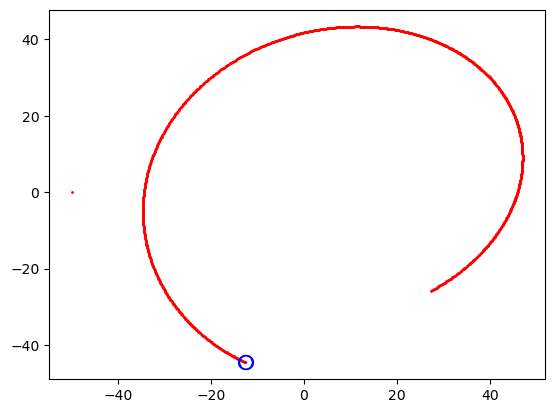

In [13]:
plt.scatter(orbit_pos_p[:, 0], orbit_pos_p[:, 1], s=1, c='r')
plt.scatter(orbit_pos_N[:, 0, 0], orbit_pos_N[:, 0, 1], s=1, c='b', linewidths=10)

In [156]:
plt.sca

(3, 2)